In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../source")

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show

output_notebook()


# Match analytics library (In progress)
from Match_Analytics import Match
from Tracking_Dynamics import calc_player_norm_positions
from Tracking_Visualization import plot_sliding_window, play_match,  draw_pitch
from Tracking_Filters import possesion_filter, ball_position_filter, time_window
from Tracking_Statistics import bivariate_normal_distribution

Loading BokehJS ...

In [2]:
m = [Match(data_source="metrica-sports", match_id=i) for i in [1,2]]

Initializing match: 1

Reading team: home
Reading team: away
Match preprocessed successfully.

Initializing match: 2

Reading team: home
Reading team: away
Match preprocessed successfully.



In [6]:
def rolling_window(tracking_data, players = None, window=5):
    temp_df = tracking_data[["Period", "Time [s]"]].copy()
    window = int(window/0.04)
    temp_df["mqd"] = 0
    
    for player in players:
        temp_df[f"{player}_x"] = tracking_data[f"{player}_x"].rolling(window).mean()
        temp_df[f"{player}_y"] = tracking_data[f"{player}_y"].rolling(window).mean()
        temp_df[f"{player}_normx"] = tracking_data[f"{player}_normx"].rolling(window).mean()
        temp_df[f"{player}_normy"] = tracking_data[f"{player}_normy"].rolling(window).mean()
        temp_df[f"{player}_vx"] = tracking_data[f"{player}_vx"].rolling(window).mean()
        temp_df[f"{player}_vy"] = tracking_data[f"{player}_vy"].rolling(window).mean()
        temp_df[f"{player}_std_x"] = tracking_data[f"{player}_x"].rolling(window).std()
        temp_df[f"{player}_std_y"] = tracking_data[f"{player}_y"].rolling(window).std()
        temp_df[f"{player}_std_normx"] = tracking_data[f"{player}_normx"].rolling(window).std()
        temp_df[f"{player}_std_normy"] = tracking_data[f"{player}_normy"].rolling(window).std()
        temp_df[f"{player}_std_vx"] = tracking_data[f"{player}_vx"].rolling(window).std()
        temp_df[f"{player}_std_vy"] = tracking_data[f"{player}_vy"].rolling(window).std()
        temp_df[f"{player}_max_vx"] = tracking_data[f"{player}_vx"].rolling(window).max()
        temp_df[f"{player}_min_vx"] = tracking_data[f"{player}_vx"].rolling(window).min()
        temp_df["mqd"] = temp_df["mqd"].add(
            ((tracking_data[f"{player}_normx"]-temp_df[f"{player}_normx"])**2+
            (tracking_data[f"{player}_normy"]-temp_df[f"{player}_normy"])**2)/11, fill_value=0)
        temp_df[f"{player}_excursion"] = ((tracking_data[f"{player}_normx"]-temp_df[f"{player}_normx"])**2+
            (tracking_data[f"{player}_normy"]-temp_df[f"{player}_normy"])**2)
    temp_df["ball_normx"] = tracking_data["ball_normx"].rolling(window).mean()
    temp_df["ball_normy"] = tracking_data["ball_normy"].rolling(window).mean()
    
    return temp_df

In [7]:
rolling = rolling_window(m[0].tracking_away, m[0].away_players, window = 60*2)
rolling_ball = rolling_window(m[0].tracking_away, m[0].away_players, window = 1)

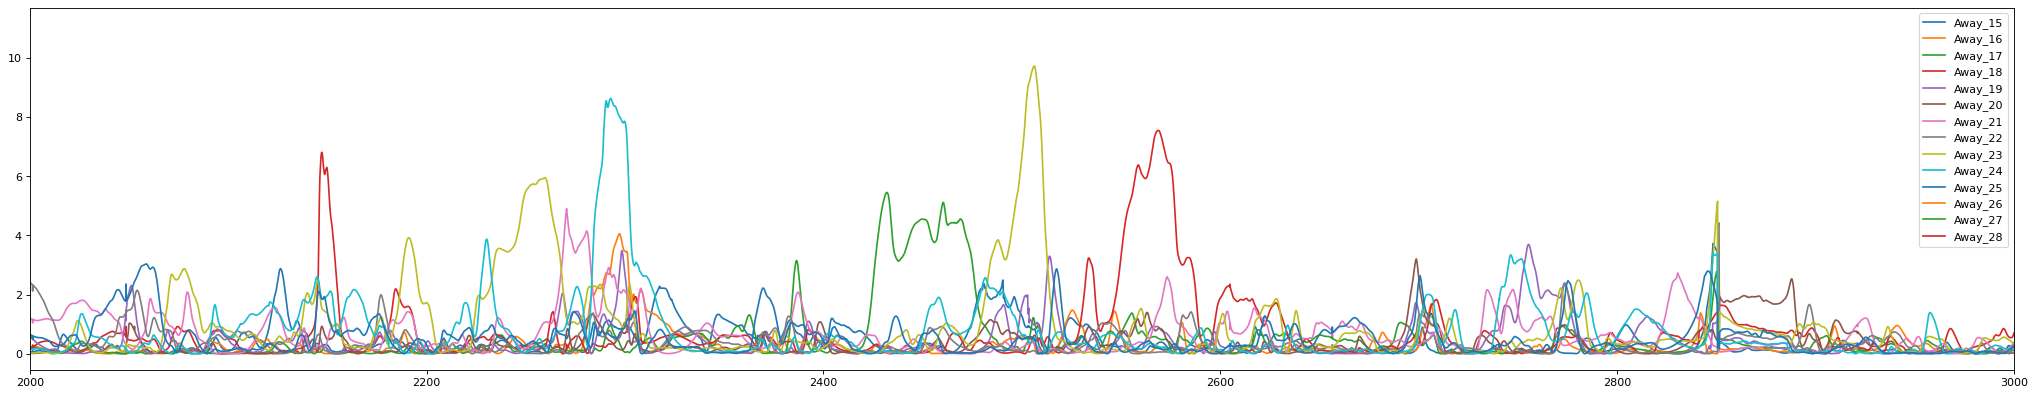

In [8]:
fig = plt.figure(figsize=(32, 6), dpi=80)

for player in m[0].away_players:
    plt.plot(rolling["Time [s]"], rolling[f"{player}_excursion"], label=f"{player}")

plt.xlim([2000,3000])

plt.legend()
plt.show()

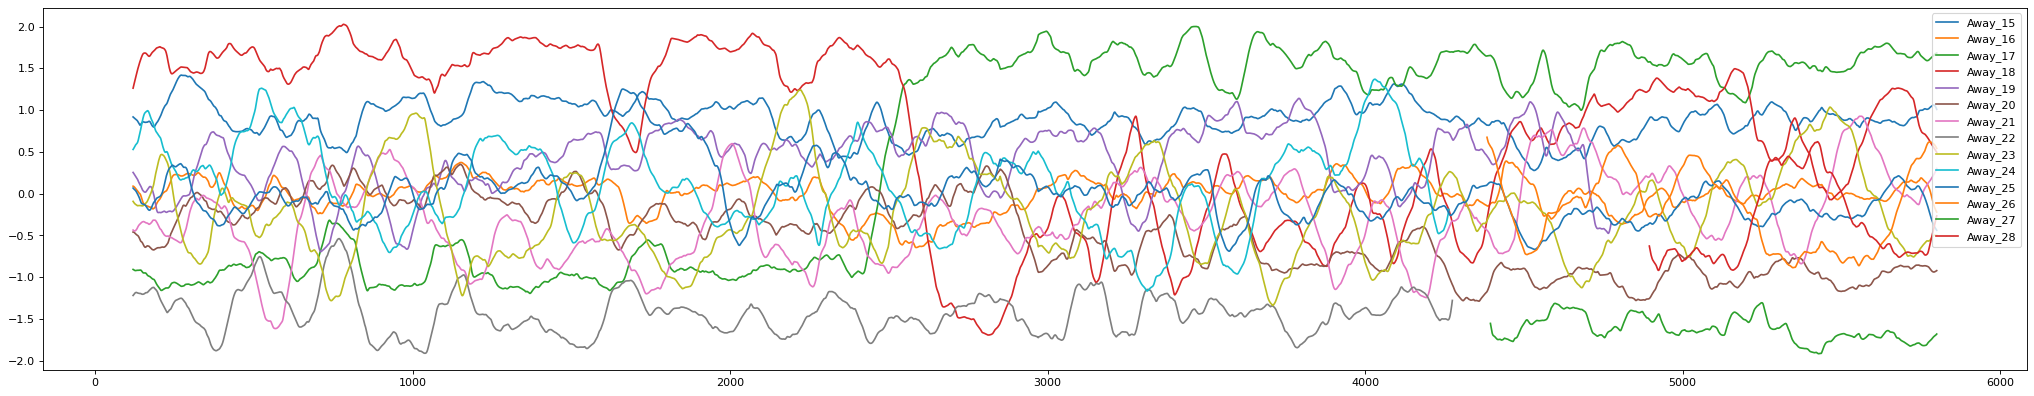

In [9]:
fig = plt.figure(figsize=(32, 6), dpi=80)

for player in m[0].away_players:
    plt.plot(rolling["Time [s]"], rolling[f"{player}_normy"], label=f"{player}")

#plt.xlim([2000,3000])

plt.legend()
plt.show()

In [10]:
data = m[0].events[m[0].events['Type']=='PASS'].groupby(['From',
                                                             'To',
                                                             'Start Time [s]',
                                                             'End Time [s]',
                                                             'Start X',
                                                             'Start Y',
                                                             'End X',
                                                             'End Y']).size().reset_index(name="Freq")
data = data.groupby(['From','To']).sum().reset_index()
data = data.apply(lambda x: x/data['Freq'] if x.name in [ 'Start Time [s]', 
                                                          'End Time [s]',
                                                          'Start X',
                                                          'End X',
                                                          'Start Y', 
                                                          'End Y',
                                                         ] else x)

In [11]:
bivariate = pd.concat([bivariate_normal_distribution(m[0].tracking_home, m[0].home_players), bivariate_normal_distribution(m[0].tracking_away, m[0].away_players)])

In [12]:
data["Start X mean"] = [float(bivariate.loc[bivariate['player']==player, 'x_mean']) for player in data['From']]
data["Start Y mean"] = [float(bivariate.loc[bivariate['player']==player, 'y_mean']) for player in data['From']]
data["End X mean"] = [float(bivariate.loc[bivariate['player']==player, 'x_mean']) for player in data['To']]
data["End Y mean"] = [float(bivariate.loc[bivariate['player']==player, 'y_mean']) for player in data['To']]
data['color'] = np.where(data["From"].str.split("_").str[0] == "Away", "blue", "red")

In [13]:
p = draw_pitch()
p.segment(x0=data["Start X mean"], y0=data["Start Y mean"], x1=data["End X mean"],
          y1=data["End Y mean"], color=data['color'], line_width=3*data["Freq"]/data['Freq'].max(), alpha=data["Freq"]/data['Freq'].max())

GlyphRenderer(id='1119', ...)

In [14]:
show(p)

In [15]:
bivariate

player_number   player     x_mean     y_mean      distance  normx_mean  \
0              1   Home_1  -6.173341 -16.906055   3152.223284   -0.084360   
1             10  Home_10   9.783362  -0.407775   8266.585041    1.009377   
2             11  Home_11 -41.411241   0.011359   4131.088144   -2.235145   
3             12  Home_12  -4.058436   0.190412   7447.300295    0.144804   
4             13  Home_13   8.414458  -1.988060   2330.486065    1.221132   
5             14  Home_14   0.897543 -15.744409   2067.287486    0.595059   
6              2   Home_2 -14.217042  -7.723728  10312.759676   -0.541939   
7              3   Home_3 -14.187656   3.167654  10404.895294   -0.546883   
8              4   Home_4 -11.476132  15.342939  10718.520967   -0.374025   
9              5   Home_5   1.764134 -12.081771  12050.117644    0.466710   
10             6   Home_6  -0.765503  -1.934049   8736.711745    0.227162   
11             7   Home_7  -7.900628 -12.676821  11391.403893   -0.145945   
12             8   Home_8   6.016889  17.631019  12196.306597    0.745279   
13             9   Home_9  12.155840   0.219617  10652.610016    1.157781   
0             15  Away_15  14.961078   9.849219  10307.160664    0.489569   
1             16  Away_16  16.202709  -1.266822  10109.459293    0.540451   
2             17  Away_17   9.757308   5.174168  11772.036334    0.173889   
3             18  Away_18  -0.355513   7.675650  12020.380664   -0.504757   
4             19  Away_19   1.949534   3.557192   9757.267139   -0.412904   
5             20  Away_20  11.474971  -7.333117  10297.983379    0.260719   
6             21  Away_21   3.857140  -4.460956  10520.468815   -0.231642   
7             22  Away_22   7.952235 -19.605011   8812.440081   -0.058034   
8             23  Away_23 -10.400404  -3.305708  10411.735534   -1.232467   
9             24  Away_24  -8.559936  -0.884885   7962.751270   -1.177547   
10            25  Away_25  41.160953  -1.218422   5156.082274    2.205970   
11            26  Away_26 -14.128177   0.108221   2817.002061   -1.100864   
12            27  Away_27  -2.963197 -17.684277   3201.223267   -0.355957   
13            28  Away_28  -1.625974  -2.716960   2129.675630   -0.386443   

    normy_mean  cov_x_std  cov_y_std  cov_angle      x_std      y_std  \
0    -1.142958  21.903171  10.586411  -0.031662  21.894758  10.603800   
1     0.079347  19.285866  16.399735  -0.072888  19.271700  16.416379   
2     0.012312   8.089448   3.486001  -0.037136   8.084907   3.496521   
3    -0.005337  18.748326  11.653913  -0.066906  18.722598  11.695202   
4    -0.289351  17.234414  11.083093  -0.341529  16.657878  11.932102   
5    -1.266051  19.162830  10.849685  -0.074893  19.126349  10.913866   
6    -0.540585  19.388060  10.682099  -0.012868  19.386943  10.684128   
7     0.286440  20.285073   9.167239   0.035863  20.274694   9.190170   
8     1.231702  19.395914   9.069996  -0.054411  19.373490   9.117795   
9    -0.916788  21.547333  12.061931  -0.011096  21.546423  12.063558   
10   -0.045391  21.928160  13.361036  -0.101434  21.857361  13.476544   
11   -0.904069  20.255594  14.034360   0.017232  20.254031  14.036616   
12    1.390852  22.164182   9.880343  -0.007354  22.163702   9.881421   
13    0.054560  20.051303  13.068327  -0.027645  20.046896  13.075087   
0     0.893442  19.693364   8.845425   0.085687  19.635709   8.972683   
1    -0.010943  17.161613   8.393894   0.103969  17.091157   8.536437   
2     0.522727  23.536378  17.196173   0.529100  22.094424  19.013307   
3     0.742344  21.421966  15.604683  -0.038829  21.414389  15.615079   
4     0.411237  20.229951  12.659594   0.141260  20.107600  12.853042   
5    -0.507037  19.241540  10.668018  -0.014797  19.240081  10.670649   
6    -0.276698  20.376934  14.098734  -0.117237  20.304141  14.203366   
7    -1.422319  22.155158   9.078488  -0.222231  21.702760  10.112378   
8    -0.208114  18.972470  13.117362   0.106618  18.916312  13.198217   
9     0.100125  2